<a href="https://colab.research.google.com/github/yingzibu/Data_Fraud/blob/main/Benford/orig_paper_1938_benford_law.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Benford, Frank. "The law of anomalous numbers." Proceedings of the American philosophical society (1938): 551-572.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from tqdm import tqdm

# Benford's law

Code reference: https://github.com/milcent/benford_py/tree/master

\begin{align}
P(D_1 = d_1, D_2 = d_2, \cdots, D_k = D_k) &= \log_{10} (1 + \frac{1}{d_1 d_2 \cdots d_k}) \\
P(D_k = d_k) & = \sum_{d_1=1}^{9} \cdots \sum_{d_{k-1} =0}^9 \log_{10} (1 + \frac{1}{d_1 d_2 \cdots d_k})
\end{align}

In [54]:
def digit2num(num_list):
    """
    Input: num_list, ordered, [digit 1, digit 2, ... digit n]
    Output: the number
    """
    try: assert num_list[0] != 0 # the first digit should not be 0
    except: print('first digit should not be 0!'); return 0
    n = len(num_list)
    num_here = 0
    for idx, i in enumerate(num_list):
        assert i >= 1 and i <= 9
        num_here += 10 ** (n - idx - 1) * i
    return num_here

def prob_first_n_digits(num_list):
    """
    Input: num_list, ordered list, [digit 1, digit 2, ... digit n]; or number
    Output: the probability of the first n digits
    """
    if type(num_list) == list:
        num_here = digit2num(num_list)
    else: num_here = int(num_list)
    # print(num_here)
    if num_here == 0: return 0

    return math.log10(1+1/num_here)

def inverse_num(num, n=None):
    """
    Input: a number, e.g., 105
    Ouput: a number, e.g., 501
    if specify n which indicates the number of digits, will append 0
    e.g. num = 9, n = 3, will return 900
    """
    digit_list = [digit for digit in str(num)]
    reversed_list = digit_list[::-1]
    string_num = "".join(digit for digit in reversed_list)
    num_here = int(string_num)
    if n != None:
        len_ = len(reversed_list)
        return num_here * 10 ** (n - len_)

    return int(string_num)

def prob_nth_digit(num, n):
    """
    Input:num, a number, the nth digit, range [0,9], if first digit [1,9]
    Input:n, the digit's position in the number, 1st, 2nd, 3rd, etc...
    Output: the probability of numbers' n th digit equals to num
    """
    prob = 0
    if n == 1: return prob_first_n_digits(num)
    for i in range(num * 10 **(n-1)+1, (num+1)* 10 **(n-1)):
        prob += prob_first_n_digits(inverse_num(i, n=n))
    return prob


### Table 3. Frequency of digits in first and second places

In [56]:
print('-> TABLE III Frequency of digits in first and second places\n')
digits = []; prob_1st = []; prob_2nd = []
data_df = pd.DataFrame()
for i in range(0, 10):
    digits.append(i)
    prob_1st.append(prob_nth_digit(i, 1))
    prob_2nd.append(prob_nth_digit(i, 2))

data_df['Digit'] = digits
data_df['First Place'] = prob_1st
data_df['Second Place'] = prob_2nd
data_df

-> TABLE III Frequency of digits in first and second places



,Digit,First Place,Second Place
0,0,0.000000,0.119679
1,1,0.301030,0.113890
2,2,0.176091,0.108821
3,3,0.124939,0.104330
4,4,0.096910,0.100308
5,5,0.079181,0.096677
6,6,0.066947,0.093375
7,7,0.057992,0.090352
8,8,0.051153,0.087570
9,9,0.045757,0.084997


### Figure 1. computed frequencies for multi-digit numbers

Do not have observed data

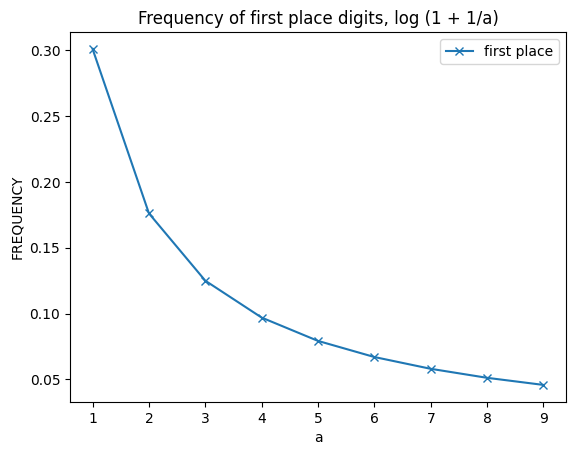

In [68]:
x = np.arange(1, 10)
y = [prob_nth_digit(x, 1) for x in range(1,10)]
plt.plot(x, y, 'x-',label='first place')
plt.xlabel('a')
plt.ylabel('FREQUENCY')
plt.title('Frequency of first place digits, log (1 + 1/a)')
plt.legend(); plt.show(); plt.close()

## PART II: Geometric basis of the law

In [102]:
def first_n_digits(num, n):
    num = abs(num)
    if num == 0: return 'NA'
    exponent = math.floor(math.log10(abs(num)))
    num = num / (10 ** exponent) # normalize to avoid extreme large/small num
    num_list = str(f'{num:.10f}').split('.')
    assert len(num_list) == 2
    num_str = num_list[0] + num_list[1]
    num_str = str(f'{float(num_str):.1f}')

    if n >= len(num_str):
        print('digits exceed length of num'); return

    try: return int(num_str[:n])
    except: print(num)

def the_nth_digit(num, n):
    n_here = first_n_digits(num, n)
    return int(str(n_here)[-1])

a = 0.000002412830; b = 10328402323
first_n_digits(a, 3), the_nth_digit(a, 2), first_n_digits(b, 3), the_nth_digit(b, 2)

(241, 4, 103, 0)

Let us assume that each individual number in the natural number system up to $n$ is used exactly as often as every other individual number.

Starting with 1 counting up to 10000, 1 would have been used 1112 times, or 11.12 percent of all uses


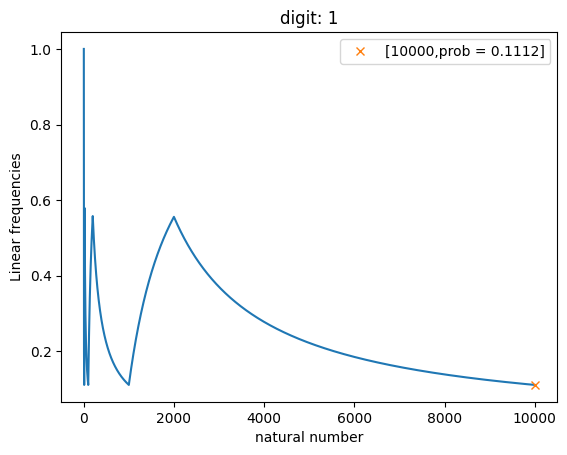

In [112]:
digit_here = 1
digit_count = 0
digit_prob = []
for i in range(1, 10000+1):
    d = the_nth_digit(i, n=1) #
    if d == digit_here: digit_count += 1
    digit_prob.append(digit_count/i)
print('Starting with 1 counting up to 10000, 1 would have been used', end="")
print(f' {digit_count} times, or {digit_prob[-1]*100:.2f} percent of all uses')
plt.plot(np.arange(1, 10000+1), digit_prob)
plt.plot(10000, digit_prob[10000-1], 'x',
         label=f'[10000,prob = {digit_prob[10000-1]:.4f}]')
plt.xlabel('natural number')
plt.ylabel('Linear frequencies')
plt.title(f'digit: {digit_here}')
plt.legend(); plt.show(); plt.close()

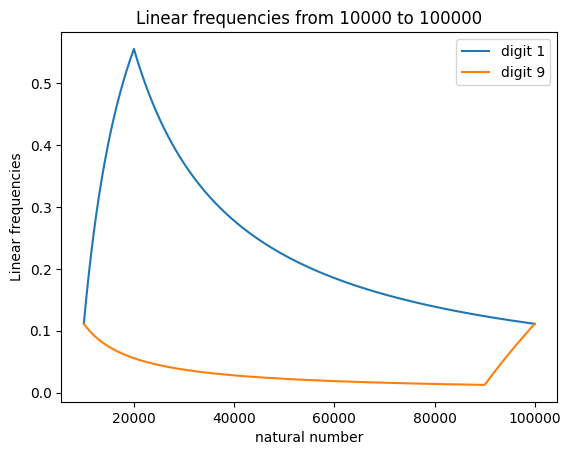

In [127]:
def value2index(v, l:list):
    """
    Input: v, a value to find
    Input: l, a list of values
    Output: the index of v in l
    """
    assert v in l
    return l.index(v)

digit_list = [1, 9]
count_list = [0] * len(digit_list)
prob_dict = {}
for i in digit_list: prob_dict[i] = []

max_value = 10 ** 5 + 1
for i in range(1, max_value+1):
    d = the_nth_digit(i, n=1) #
    if d in digit_list:
        idx = value2index(d, digit_list)
        count_list[idx] += 1
    for digit in digit_list:
        idx = value2index(digit, digit_list)
        prob_dict[digit].append(count_list[idx]/i)
    # if d == digit_here: digit_count += 1
    # digit_prob.append(digit_count/i)

min_value = 10 ** 4
for i in digit_list:
    plt.plot(np.arange(min_value, max_value),
             prob_dict[i][min_value-1:max_value-1],
             label=f'digit {i}')
    # plt.plot(10000, digit_prob[10000-1], 'x',
    #      label=f'[10000,prob = {digit_prob[10000-1]:.4f}]')
plt.xlabel('natural number')
plt.ylabel('Linear frequencies')
plt.title(f'Linear frequencies from {min_value} to {max_value-1}')
plt.legend(); plt.show(); plt.close()

In [170]:
min_, max_ = 1e4, 2 * 1e4
print(f'range: [{min_}, {max_}]')
for i in digit_list:
    AUC_i = sum(prob_dict[i][int(min_-1):int(max_-1)])
    AUC_i = AUC_i - 0.5 * prob_dict[i][int(min_-1)] + 0.5 * prob_dict[i][int(max_)]
    AUC_i /= (max_-min_)
    print(f'digit {i}: AUC = {AUC_i:.4f}')

min_, max_ = 2e4, 1e5-1
print(f'range: [{min_}, {max_}]')
for i in digit_list:
    AUC_i = sum(prob_dict[i][int(min_-1):int(max_-1)])
    AUC_i = AUC_i - 0.5 * prob_dict[i][int(min_-1)] + 0.5 * prob_dict[i][int(max_)]
    AUC_i /= (max_-min_)
    print(f'digit {i}: AUC = {AUC_i:.4f}')

min_, max_ = 1e5-1, 1e5
print(f'range: [{min_}, {max_}]')
for i in digit_list:
    AUC_i = sum(prob_dict[i][int(min_-1):int(max_-1)])
    AUC_i = AUC_i - 0.5 * prob_dict[i][int(min_-1)] + 0.5 * prob_dict[i][int(max_)]
    AUC_i /= (max_-min_)
    print(f'digit {i}: AUC = {AUC_i:.4f}')

min_, max_ = 1e4, 1e5
print(f'range: [{min_}, {max_}]')
for i in digit_list:
    AUC_i = sum(prob_dict[i][int(min_-1):int(max_-1)])
    AUC_i = AUC_i - 0.5 * prob_dict[i][int(min_-1)] + 0.5 * prob_dict[i][int(max_)]
    AUC_i /= (max_-min_)
    print(f'digit {i}: AUC = {AUC_i:.4f}')

min_, max_ = 1, 1e5
print(f'range: [{min_}, {max_}]')
for i in digit_list:
    AUC_i = sum(prob_dict[i][int(min_-1):int(max_-1)])
    AUC_i = AUC_i - 0.5 * prob_dict[i][int(min_-1)] + 0.5 * prob_dict[i][int(max_)]
    AUC_i /= (max_-min_)
    print(f'digit {i}: AUC = {AUC_i:.4f}')


range: [10000.0, 20000.0]
digit 1: AUC = 0.3839
digit 9: AUC = 0.0770
range: [20000.0, 99999.0]
digit 1: AUC = 0.2235
digit 9: AUC = 0.0288
range: [99999.0, 100000.0]
digit 1: AUC = 0.1111
digit 9: AUC = 0.1111
range: [10000.0, 100000.0]
digit 1: AUC = 0.2414
digit 9: AUC = 0.0342
range: [1, 100000.0]
digit 1: AUC = 0.2414
digit 9: AUC = 0.0342


Fig 2. Linear frequencies of the natural number system between10000 and 100000 




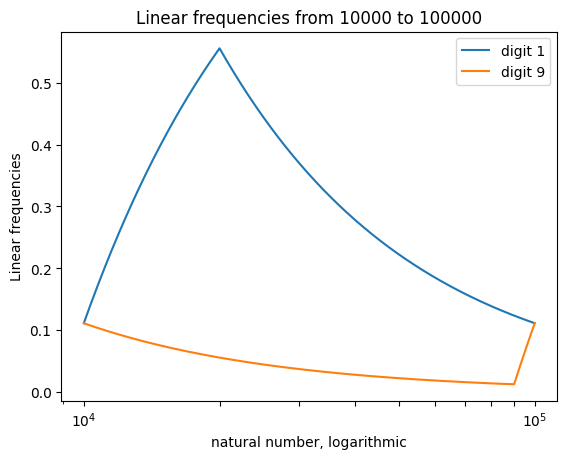

In [148]:
print('Fig 2. Linear frequencies of the natural number system between', end='')
print(f'{min_value} and {max_value-1} \n\n')
for i in digit_list:
    plt.plot(np.arange(min_value, max_value),
             prob_dict[i][min_value-1:max_value-1],
             label=f'digit {i}')

plt.xscale('log')
xticks = np.arange(min_value,  max_value, 1e4)
plt.xticks(xticks)  # Assuming base-10 logarithm
plt.xlabel('natural number, logarithmic')
plt.ylabel('Linear frequencies')
plt.title(f'Linear frequencies from {min_value} to {max_value-1}')
plt.legend(); plt.show(); plt.close()

In [184]:
def cal_AUC_log(min_, max_, digit_list=digit_list, prob_dict=prob_dict):
    dxs = 0
    auc_dict = {}
    for d in digit_list: auc_dict[d] = 0
    min_ = int(min_); max_ = int(max_)
    for i in range(min_,max_+1):
        dx_here = math.log(i+1) - math.log(i)
        dxs += dx_here
        for d in digit_list:
            y_ave = (prob_dict[d][i-1] + prob_dict[d][i])/2
            auc_dict[d] += y_ave * dx_here
    for d in digit_list:
        auc_dict[d] /= dxs
    return auc_dict

min_, max_ = 1e4, 2 * 1e4
print(f'range: [{min_}, {max_}]')
print(cal_AUC_log(min_, max_))

min_, max_ = 2e4, 1e5-1
print(f'range: [{min_}, {max_}]')
print(cal_AUC_log(min_, max_))

min_, max_ = 1e5-1, 1e5
print(f'range: [{min_}, {max_}]')
print(cal_AUC_log(min_, max_))

min_, max_ = 1, 1e5
print(f'range: [{min_}, {max_}]')
print(cal_AUC_log(min_, max_))

min_, max_ = 1e4, 1e5
print(f'range: [{min_}, {max_}]')
print(cal_AUC_log(min_, max_))

range: [10000.0, 20000.0]
{1: 0.3588805070625358, 9: 0.08013993571559777}
range: [20000.0, 99999.0]
{1: 0.2761460983705228, 9: 0.030943490518527572}
range: [99999.0, 100000.0]
{1: 0.11111999993333398, 9: 0.11111000000833325}
range: [1, 100000.0]
{1: 0.32520002034167333, 9: 0.03728601695784258}
range: [10000.0, 100000.0]
{1: 0.3010465420278292, 9: 0.04575391401740339}


In [ ]:
digit_df = pd.DataFrame()
digit_df['concentration'] = df['concentration'][df['concentration']>0]
for digit_num in range(1, 4):

    digit_list = []
    for i in digit_df['concentration']:
        digit_list.append(first_n_digits(i, digit_num))
    digit_df[f'digit_{digit_num}'] = digit_list
digit_df = digit_df.reset_index(drop=True)
digit_df

,concentration,digit_1,digit_2,digit_3
0,5.228267,5,52,522
1,3.112396,3,31,311
2,1.499375,1,14,149
3,0.804644,8,80,804
4,0.784734,7,78,784
...,...,...,...,...
106242,0.393370,3,39,393
106243,0.187636,1,18,187
106244,0.054874,5,54,548
106245,0.034609,3,34,346


  0%|          | 0/3 [00:00<?, ?it/s]

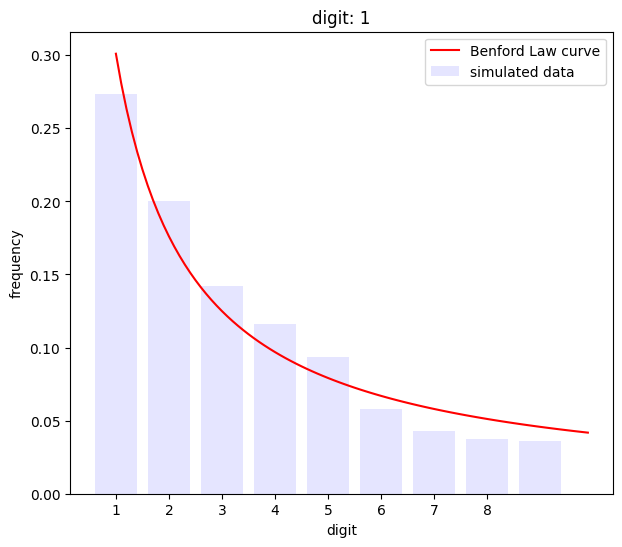

 33%|███▎      | 1/3 [00:00<00:00,  6.88it/s]

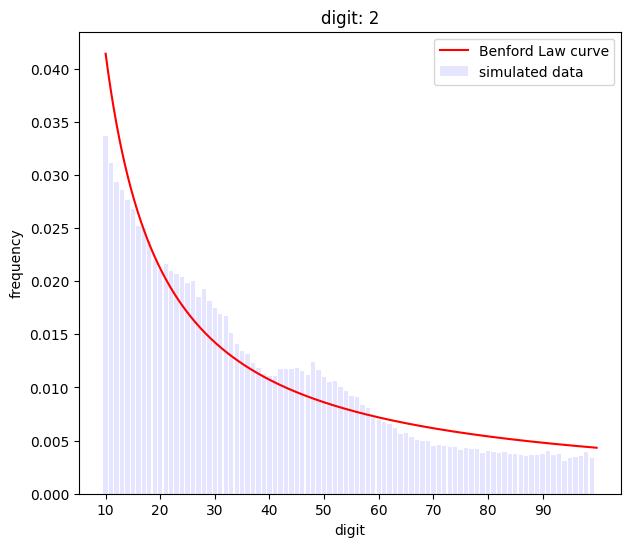

 67%|██████▋   | 2/3 [00:00<00:00,  4.59it/s]

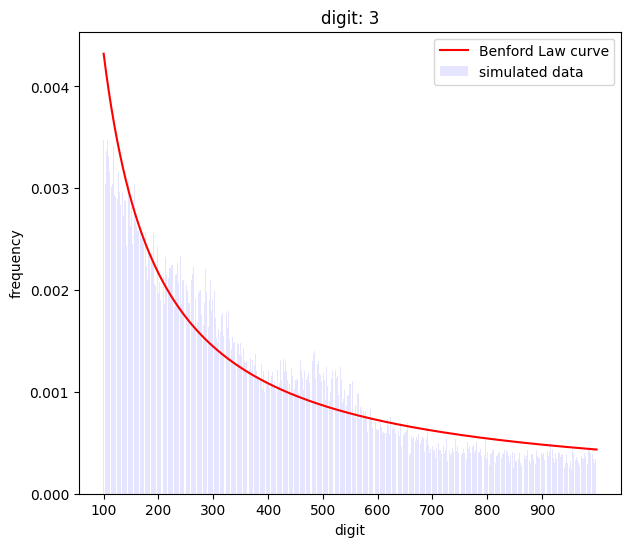

100%|██████████| 3/3 [00:01<00:00,  2.00it/s]


In [ ]:
for digit_num in tqdm(range(1,4)):
    data_here = digit_df[f'digit_{digit_num}']
    a = data_here.value_counts(ascending=False)
    total_num = len(digit_df)
    cats = []
    freq = []
    for i,j in a.items():
        # print(i,j/total_num)
        cats.append(i); freq.append(j/total_num)
    max_digit = data_here.max()
    min_digit = data_here.min()

    plt.bar(cats, freq, color='blue', alpha=0.1, label='simulated data')
    x = np.arange(min_digit, max_digit+1, 0.1)
    y = [math.log10(1+1/i) for i in x]
    plt.plot(x, y, color='red', label='Benford Law curve')


    # x = np.arange(min_digit, max_digit+1, 1)
    # y = [math.log10(1+1/i) for i in x]
    # plt.plot(x, y, '*', color='red')

    plt.xlabel('digit'); plt.ylabel('frequency')
    plt.title(f'digit: {digit_num}')

    number_of_steps = 10**(digit_num-1)
    l = np.arange(min_digit, max_digit, number_of_steps)
    plt.xticks(l)

    # plt.(xticks=l, xtickla?bels=l)
    # plt.xticks(cats)
    plt.legend(); plt.show(); plt.close()



In [ ]:
single_df = pd.DataFrame()
single_df['concentration'] = df['concentration'][df['concentration']>0]
for digit_num in range(1, 4):

    digit_list = []
    for i in single_df['concentration']:
        digit_list.append(the_nth_digit(i, digit_num))
    single_df[f'digit_{digit_num}'] = digit_list
single_df = single_df.reset_index(drop=True)
single_df

,concentration,digit_1,digit_2,digit_3
0,5.228267,5,2,2
1,3.112396,3,1,1
2,1.499375,1,4,9
3,0.804644,8,0,4
4,0.784734,7,8,4
...,...,...,...,...
106242,0.393370,3,9,3
106243,0.187636,1,8,7
106244,0.054874,5,4,8
106245,0.034609,3,4,6


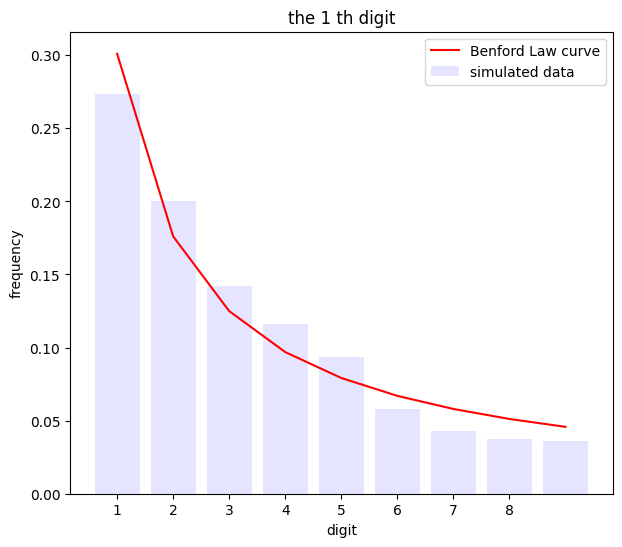

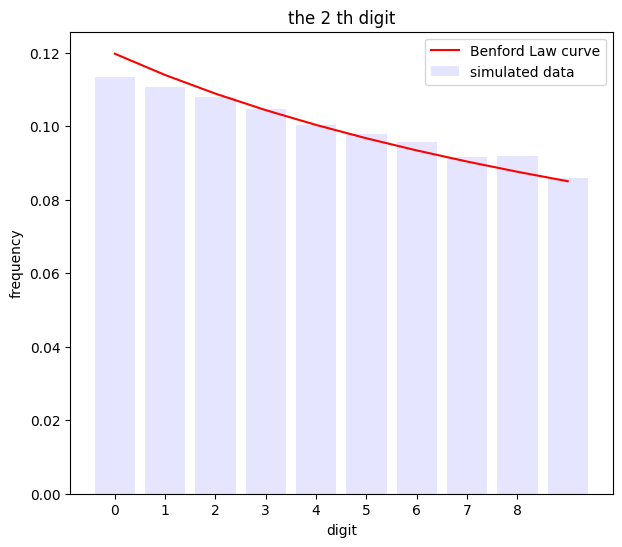

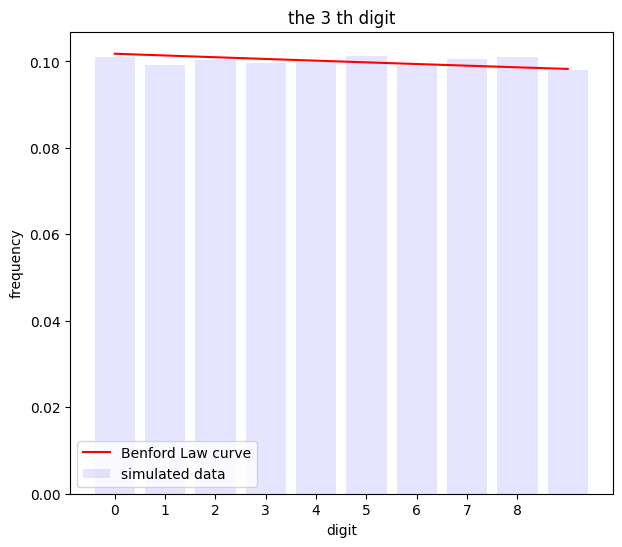

In [ ]:
for digit_num in range(1,4):
    data_here = single_df[f'digit_{digit_num}']
    a = data_here.value_counts(ascending=False)
    total_num = len(single_df)
    cats = []
    freq = []
    for i,j in a.items():
        # print(i,j/total_num)
        cats.append(i); freq.append(j/total_num)
    max_digit = data_here.max()
    min_digit = data_here.min()

    plt.bar(cats, freq, color='blue', alpha=0.1, label='simulated data')
    x = np.arange(min_digit, max_digit+1)
    if digit_num == 1:
        y = [math.log10(1+1/i) for i in x]
    elif digit_num == 2:
        y = []
        for i in x:
            y_here = 0
            for d1 in range(1,10):
                y_temp = math.log10(1 + 1/ (d1*10 + i))
                y_here += y_temp
            y.append(y_here)

    elif digit_num == 3:
        y = []
        for i in x:
            y_here = 0
            for d1 in range(1,10):
                for d2 in range(0,10):
                    y_temp = math.log10(1 + 1/ (d1*100 + d2*10 + i))
                    y_here += y_temp
            y.append(y_here)
    plt.plot(x, y, color='red', label='Benford Law curve')


    # x = np.arange(min_digit, max_digit+1, 1)
    # y = [math.log10(1+1/i) for i in x]
    # plt.plot(x, y, '*', color='red')

    plt.xlabel('digit'); plt.ylabel('frequency')
    plt.title(f'the {digit_num} th digit')

    # number_of_steps = 10**(digit_num-1)
    l = np.arange(min_digit, max_digit, 1)
    plt.xticks(l)

    # plt.(xticks=l, xtickla?bels=l)
    # plt.xticks(cats)
    plt.legend(); plt.show(); plt.close()

